# TODO

- ~~noisy~~
- optimalizace diskretnich hyperparam

- benchmark + proc approx?
- paralelni
- expected imrpovement per second (vetsi hyperaram me stoji vic trenovani)
- v prubehu zjistim

- kernely
- acquisition funkce

In [51]:
from myopt.kernels import Linear

In [57]:
np.array([[1, 2]]).reshape(len)

array([[1],
       [2]])

In [55]:
Linear()(np.array([2]), np.array([3]))

array([[6.]])

In [50]:
np.array([3, 4]).reshape(-1, 1)

array([[3],
       [4]])

In [41]:
a = np.array([[1,-1], [2,-2]])
b = np.array([[5, -5], [6, -6]])

x, y = np.meshgrid(a, b)
print(x)
print(y)

[[ 1 -1  2 -2]
 [ 1 -1  2 -2]
 [ 1 -1  2 -2]
 [ 1 -1  2 -2]]
[[ 5  5  5  5]
 [-5 -5 -5 -5]
 [ 6  6  6  6]
 [-6 -6 -6 -6]]


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import solve, cholesky, inv
from numpy.random import multivariate_normal

from functools import partial

%matplotlib inline

from myopt.plot import plots, plot_gp, plot_gp_prior
from myopt.kernels import SquaredExp
from myopt.gaussian_process import GaussianProcess

In the basic form we have $K = k(X_{\text{train}}, X_{\text{train}}), K_* = k(X_{\text{train}}, X_{\text{test}}), K_{**} = k(X_{\text{test}}, X_{\text{test}})$, which gives us the following posterior

$$
\begin{align}
    \mu &= K_* K^{-1} y \\
    var &= K_{**} - K_* K^{-1} K_*^T.
\end{align}
$$

We can also write

$$
\begin{align}
    L &= cholesky(K) \\
    \alpha &= L^T \backslash (L \backslash y) \\
    \mu &= K_*^T \alpha \\
    v &= L \backslash K_* \\
    var &= K_{**} - v^T v,
\end{align}
$$

and we also know that

$$
(L \backslash K_*)^T (L \backslash y) = K_*^T (L^T \backslash (L \backslash y)) = K_* K^{-1} y
$$

## GP regression (ignoring noisy for now)

We condition on the training data and compute the posterior for the test data $X_{\text{test}}$. Since the posterior is Gaussian, it is fully defined by its mean and covariance, which we can compute in closed form

$$
\begin{align}
    \mu_* &= K_*^T K_*^{-1} y \\
    \Sigma_* &= K_{**} - K_*^T K_*^{-1} K_*
\end{align}
$$

In [3]:
X_train = np.array([0, 0.3, 2, 4])
y_train = np.sin(X_train)

X = np.arange(min(X_train) - 0.5, max(X_train) + 0.5, step=0.1)

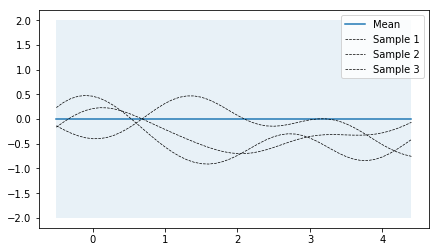

In [4]:
GaussianProcess().plot_prior(X)

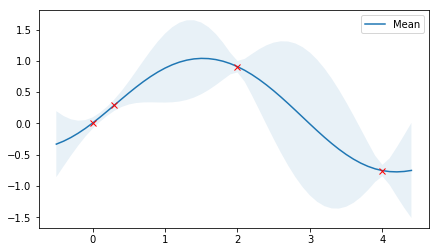

In [11]:
GaussianProcess().with_noise(.002).posterior(X, X_train, y_train).plot_posterior(num_samples=0)

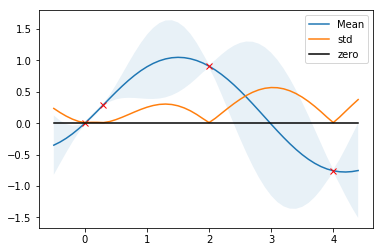

In [19]:
gp = GaussianProcess().with_noise(0.00002).posterior(X, X_train, y_train)
gp.plot_posterior(num_samples=0, figure=False)
plt.plot(X, np.sqrt(np.diag(gp.cov)), label="std")
plt.plot(X, np.zeros_like(X), label="zero", c="k")
plt.legend()

## Kernel params

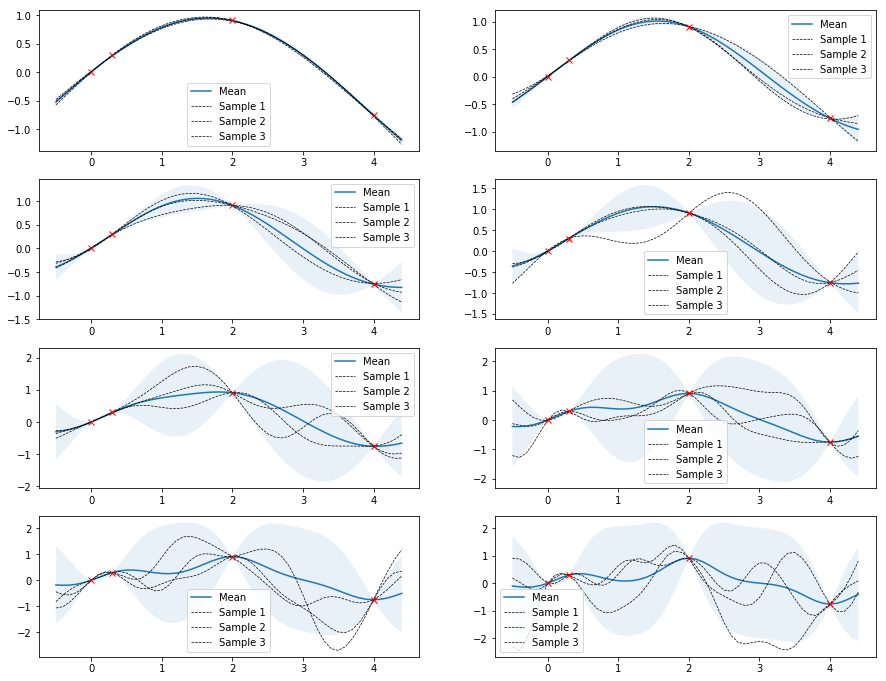

In [20]:
params = [0.1, 0.3, 0.6, 0.9, 2, 4, 5, 8]

gp = GaussianProcess()

plt.figure(figsize=(15,15))
for i, l in enumerate(params):
    num_rows = len(params) // 2 + 1

    plt.subplot(num_rows, 2, i+1)
    
    gp.with_kernel_params([l]).fit(X_train, y_train).posterior(X).plot_posterior(figure=False)

## Optimizing kernel parameters

$$
\begin{align}
    \log p(y|X) &= \log N(y|0, K_y) \\
                &= -\frac{1}{2} y^T K_y^{-1} y - \frac{1}{2} \log |K_y| - \frac{N}{2} \log(2 \pi)
\end{align}
$$

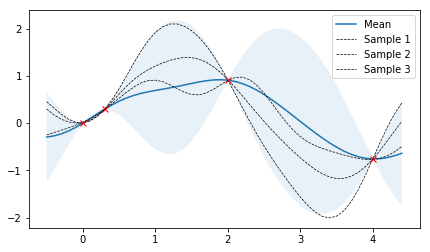

In [24]:
gp = GaussianProcess()
gp.optimize_kernel(X_train, y_train).posterior(X, X_train, y_train).plot_posterior()

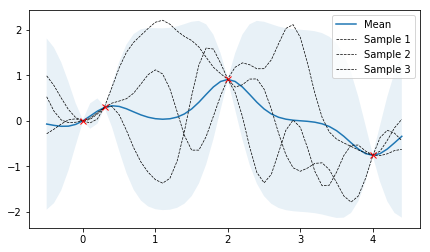

In [28]:
# gp.optimize_kernel(X_train, y_train).posterior(X).plot_posterior()
gp = GaussianProcess()
gp.with_kernel_params([10]).posterior(X, X_train, y_train).plot_posterior()

In [110]:
X_test = np.arange(-5, 5, 0.1)

# Noisy training data
X_train = np.arange(-3, 4, 1)
y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

In [2]:
GaussianProcess().optimize_kernel(X_train, y_train).fit(X_train, y_train).posterior(X_test).plot_posterior()

NameError: name 'GaussianProcess' is not defined

# Bayesian Optimization

http://krasserm.github.io/2018/03/21/bayesian-optimization/

In [17]:
from myopt.bayesian_optimization import plot_acquisition, plot_approximation, plot_convergence

In [18]:
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

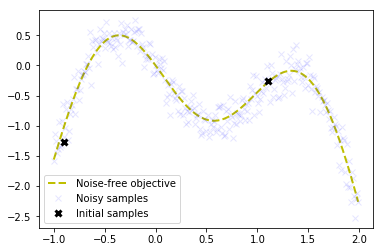

In [19]:
# Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', mew=3, label='Initial samples')
plt.legend();

In [20]:
from myopt.acquisition_functions import expected_improvement
from myopt.bayesian_optimization import propose_location

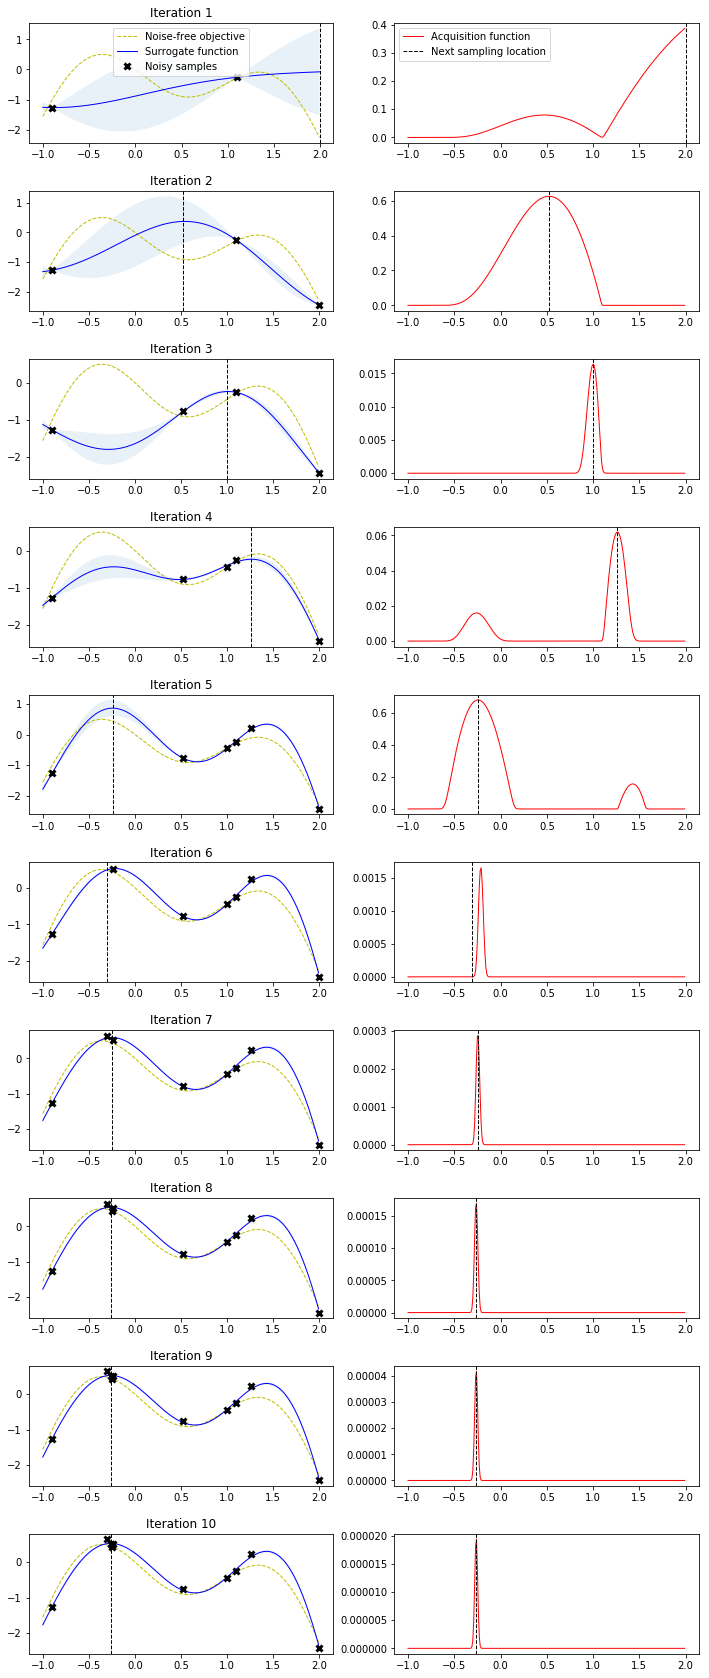

In [21]:
X_sample = X_init
y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, y_sample, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(X, Y, X_sample, y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, y_sample), X_next, show_legend=i==0)
    
    X_sample = np.vstack((X_sample, X_next))
    y_sample = np.vstack((y_sample, Y_next))

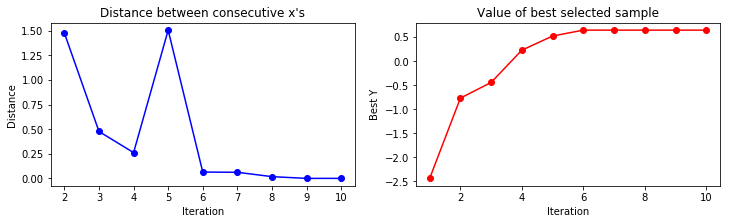

In [22]:
plot_convergence(X_sample, y_sample)